In [1]:
import torch
import time
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps"  if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [3]:
DAE_np_data_path = r'data\np\npData.csv'

np_DAE_df = pd.read_csv(DAE_np_data_path)

In [4]:
np_DAE_df = np_DAE_df[np_DAE_df['author1'] != 'K.H.Hicks+'] # Dataset has multiple authors, we keep only B.K.Park+ to ensure only one target material...

In [5]:
df = np_DAE_df[['x2(eV)', 'x3(eV)', 'x4(deg)','y', 'dy']]

df = df.rename(columns={
    'x2(eV)': 'E_inc',
    'x3(eV)': 'E_sec',
    'x4(deg)': 'theta',
    'y': 'ddcs',  # double differential cross section
    'dy': 'Errddcs'  # Error on double differential cross section 

})
df = df.dropna(subset=['E_inc', 'E_sec', 'theta', 'ddcs'])

df = df[df['E_inc'] != 2.5e8]

In [6]:
# import torch
# import numpy as np
# import pandas as pd

# def prepare_experimental_data(df):
#     """
#     Integrates double differential cross section over:
#     - Outgoing proton energy (E_sec) to get dsigma/dOmega
#     - Outgoing proton angle (theta) to get dsigma/dE

#     Parameters:
#     -----------
#     df : pandas.DataFrame
#         Columns: E_inc, E_sec, theta, ddcs
        
#     Returns:
#     --------
#     tuple: (torch.Tensor, torch.Tensor, torch.Tensor)
#         - E_inc_unique: shape (n_inc,)
#         - dsigma_dOmega: shape (n_inc, n_theta)
#         - dsigma_dE: shape (n_inc, n_E_sec)
#     """

#     # Sort unique values
#     E_inc_unique = sorted(df['E_inc'].unique())
#     theta_unique = sorted(df['theta'].unique())
#     E_sec_unique = sorted(df['E_sec'].unique())

#     # Preallocate arrays
#     dsigma_dOmega = np.zeros((len(E_inc_unique), len(theta_unique)))
#     dsigma_dE = np.zeros((len(E_inc_unique), len(E_sec_unique)))

#     # Use bin widths for integration
#     theta_bin_width = np.diff(theta_unique).mean() if len(theta_unique) > 1 else 1.0
#     E_sec_bin_width = np.diff(E_sec_unique).mean() if len(E_sec_unique) > 1 else 1.0

#     # Compute dsigma/dOmega: integrate over E_sec
#     grouped_omega = df.groupby(['E_inc', 'theta'])['ddcs'].sum().reset_index()
#     for _, row in grouped_omega.iterrows():
#         e_idx = E_inc_unique.index(row['E_inc'])
#         theta_idx = theta_unique.index(row['theta'])
#         dsigma_dOmega[e_idx, theta_idx] = row['ddcs'] * E_sec_bin_width  # approximate integral

#     # Compute dsigma/dE: integrate over theta
#     grouped_E = df.groupby(['E_inc', 'E_sec'])['ddcs'].sum().reset_index()
#     for _, row in grouped_E.iterrows():
#         e_idx = E_inc_unique.index(row['E_inc'])
#         e_sec_idx = E_sec_unique.index(row['E_sec'])
#         dsigma_dE[e_idx, e_sec_idx] = row['ddcs'] * theta_bin_width  # approximate integral

#     return (
#         torch.tensor(E_inc_unique, dtype=torch.float32),
#         torch.tensor(dsigma_dOmega, dtype=torch.float32),
#         torch.tensor(dsigma_dE, dtype=torch.float32)
#     )


In [7]:
import torch
import numpy as np
import pandas as pd


def prepare_experimental_data(df):

    # incident energy 
    E_inc_unique  = sorted(df['E_inc'].unique())

    # create the grid
    E_sec_unique  = np.asarray(sorted(df['E_sec'].unique()),  dtype=float)
    theta_unique  = np.asarray(sorted(df['theta'].unique()), dtype=float)

    # create the 2D distribution
    out = []
    for E_inc in E_inc_unique:
        # Sub-select rows for this incident energy
        sub = df[df['E_inc'] == E_inc]

        # Pivot into a full 2-D grid; reindex to guarantee rectangular shape
        grid = (
            sub.pivot(index='E_sec', columns='theta', values='ddcs')
               .reindex(index=E_sec_unique, columns=theta_unique)
               .fillna(0.0)
               .to_numpy()
        )

        out.append({
            'E_inc' : torch.tensor(E_inc,        dtype=torch.float32),
            'E_sec' : torch.tensor(E_sec_unique, dtype=torch.float32),
            'theta' : torch.tensor(theta_unique, dtype=torch.float32),
            'ddcs'  : torch.tensor(grid,         dtype=torch.float32)
        })

    return out

In [8]:
out = prepare_experimental_data(df)

# same as out, but cs are integrated over theta and E_sec
# This will give us the integrated results for each incident energy
integrated_results = []

for d in out:
    E_inc = d['E_inc']
    E_sec = d['E_sec']
    theta = d['theta']
    ddcs = d['ddcs']

    int_theta = torch.trapz(ddcs, theta, dim=1)  # integrate over theta
    int_Esec = torch.trapz(ddcs, E_sec, dim=0)  # integrate over E_sec

    integrated_results.append({
        'E_inc': E_inc,
        'E_sec': E_sec,
        'theta': theta,
        'int_over_theta': int_theta,
        'int_over_E_sec': int_Esec
    })



In [9]:

def plot_integrated_cross_sections(integrated_results):
    for data in integrated_results:
        E_inc = data['E_inc'].item()  # scalar float
        E_sec = data['E_sec'].numpy()
        theta = data['theta'].numpy()
        int_over_theta = data['int_over_theta'].numpy()
        int_over_E_sec = data['int_over_E_sec'].numpy()

        # Plot integrated over theta (cross section vs E_sec)
        plt.figure(figsize=(12,5))
        plt.subplot(1, 2, 1)
        plt.plot(E_sec, int_over_theta, marker='o')
        plt.xlabel('Secondary Energy $E_{sec}$')
        plt.ylabel('Integrated Cross Section (over θ)')
        plt.title(f'Incident Energy $E_{{inc}}$ = {E_inc:.2f}')

        # Plot integrated over E_sec (cross section vs theta)
        plt.subplot(1, 2, 2)
        plt.plot(theta, int_over_E_sec, marker='o')
        plt.xlabel('Scattering Angle θ')
        plt.ylabel('Integrated Cross Section (over $E_{sec}$)')
        plt.title(f'Incident Energy $E_{{inc}}$ = {E_inc:.2f}')

        plt.tight_layout()
        plt.show()

# plot_integrated_cross_sections(integrated_results)

In [10]:
# E_inc_unique, dsigma_dOmega, dsigma_dE = prepare_experimental_data(df)

# E_inc_unique, dsigma_dOmega, dsigma_dE

# dsigma_dOmega.size(), dsigma_dE.size()

# E_inc_unique

In [11]:
# theta_values = sorted(df['theta'].unique())
# cos_theta = sorted(np.cos(np.radians(df['theta'].unique())))
# E_sec_unique = sorted(df['E_sec'].unique())



# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,10))

# for i in range(len(E_inc_unique)):    
#     ax1.plot(E_sec_unique, dsigma_dE[i], '--', label=f'E_n = {E_inc_unique[i]:.2e} eV', linewidth=2)
#     ax2.plot(cos_theta, dsigma_dOmega[i], '-', label=f'E_n = {E_inc_unique[i]:.2e} eV', linewidth=2)

# # ax1.set_title('Integrated DDCS over theta')
# # ax2.set_title('Integrated DDCS over E_sec')

# ax1.set_xlabel(r'$E_{sec}$ (eV)')
# ax1.set_ylabel(r'$\frac{d\sigma}{dE}$ [br/eV]')
# ax1.legend()
# ax1.grid(True)

# ax2.set_xlabel('Theta (deg)')
# ax2.set_ylabel(r'$\frac{d\sigma}{d\Omega}$ [br/sr]')
# ax2.legend()
# ax2.grid(True)

# plt.tight_layout()

In [ ]:
import torch
from torch import nn
import numpy as np

# class NPReactionSimulator(nn.Module):
#     def __init__(
#         self,
#         m_n=939.565,   # neutron mass [MeV/c^2]
#         m_p=938.272,   # proton mass [MeV/c^2]
#         M_A=29785.0,   # S-32 mass [MeV/c^2]
#         S_n=7.70,      # neutron separation energy [MeV]
#         S_p=13.46      # proton separation energy [MeV]
#     ):
#         super().__init__()
#         # Store physical constants as buffers for device consistency
#         self.register_buffer("m_n", torch.tensor(m_n))
#         self.register_buffer("m_p", torch.tensor(m_p))
#         self.register_buffer("M_A", torch.tensor(M_A))
#         self.register_buffer("S_n", torch.tensor(S_n))
#         self.register_buffer("S_p", torch.tensor(S_p))

#     def forward(self, Ek, r1, r2, r3):
#         """
#         Inputs:
#             Ek:  [B] neutron kinetic energy [MeV]
#             r1:  [B] ∈ [0, 1] → proton energy fraction
#             r2:  [B] ∈ [-1, 1] → cos(theta) direction
#             r3:  [B] ∈ [-π, π] → phi direction
#         Outputs:
#             Ep_lab: [B] proton energy in lab frame [MeV]
#             cos_theta_lab: [B] emission angle cosine in lab frame
#         """
#         m_n, m_p, M_A, S_n, S_p = self.m_n, self.m_p, self.M_A, self.S_n, self.S_p

#         # Recoil kinetic energy
#         denom = (M_A + m_n) ** 2
#         Tk = (Ek ** 2 * m_n) / denom

#         # Excitation energy and energy available
#         Ex = Ek - Tk + S_n
#         available_E = Ex - S_p
#         mask = available_E > 0

#         Ep_com = r1 * available_E
#         E_p_com = Ep_com + m_p
#         p_mag_com = torch.sqrt(torch.clamp(E_p_com**2 - m_p**2, min=0.0))

#         cos_theta_com = r2
#         sin_theta_com = torch.sqrt(torch.clamp(1 - cos_theta_com**2, min=0.0))
#         phi = r3

#         px_com = p_mag_com * sin_theta_com * torch.cos(phi)
#         py_com = p_mag_com * sin_theta_com * torch.sin(phi)
#         pz_com = p_mag_com * cos_theta_com

#         M_recoil = M_A + m_n
#         v_recoil = Tk / M_recoil
#         beta = v_recoil
#         gamma = 1.0 / torch.sqrt(1 - beta**2 + 1e-8)

#         # Lorentz boost
#         E_lab = gamma * (E_p_com + beta * pz_com)
#         pz_lab = gamma * (pz_com + beta * E_p_com)

#         # Transverse momenta unchanged
#         px_lab = px_com
#         py_lab = py_com
#         p_mag_lab = torch.sqrt(px_lab**2 + py_lab**2 + pz_lab**2 + 1e-8)

#         Ep_lab = E_lab - m_p
#         cos_theta_lab = pz_lab / (p_mag_lab + 1e-8)

#         # Apply reaction validity mask
#         Ep_lab = torch.where(mask, Ep_lab, torch.zeros_like(Ep_lab))
#         cos_theta_lab = torch.where(mask, cos_theta_lab, torch.zeros_like(cos_theta_lab))

#         return Ep_lab, cos_theta_lab

# ---------------------------
# Safe NPReactionSimulator
# ---------------------------

#------------------------

# class NPReactionSimulator(nn.Module):
#     def __init__(self, m_n=939.565, m_p=938.272, M_A=29785.0, S_n=7.70, S_p=13.46):
#         super().__init__()
#         self.register_buffer("m_n", torch.tensor(float(m_n)))
#         self.register_buffer("m_p", torch.tensor(float(m_p)))
#         self.register_buffer("M_A", torch.tensor(float(M_A)))
#         self.register_buffer("S_n", torch.tensor(float(S_n)))
#         self.register_buffer("S_p", torch.tensor(float(S_p)))

#     def forward(self, Ek, r1, r2, r3):
#         if Ek.dim() == 2 and Ek.shape[1] == 1:
#             Ek = Ek.view(-1)
#         if Ek.numel() == 1:
#             Ek = Ek.expand(r1.shape[0])

#         m_n, m_p, M_A, S_n, S_p = self.m_n, self.m_p, self.M_A, self.S_n, self.S_p
#         denom = (M_A + m_n) ** 2
#         Tk = (Ek ** 2 * m_n) / denom
#         Ex = Ek - Tk + S_n
#         available_E = Ex - S_p
#         mask = available_E > 0

#         Ep_com = r1 * available_E
#         E_p_com = Ep_com + m_p
#         p_mag_com = torch.sqrt(torch.clamp(E_p_com**2 - m_p**2, min=0.0))

#         cos_theta_com = r2
#         sin_theta_com = torch.sqrt(torch.clamp(1 - cos_theta_com**2, min=0.0))
#         phi = r3

#         px_com = p_mag_com * sin_theta_com * torch.cos(phi)
#         py_com = p_mag_com * sin_theta_com * torch.sin(phi)
#         pz_com = p_mag_com * cos_theta_com

#         M_recoil = M_A + m_n
#         v_recoil = Tk / M_recoil
#         beta = torch.clamp(v_recoil, max=0.999999)
#         gamma = 1.0 / torch.sqrt(1 - beta**2 + 1e-12)

#         E_lab = gamma * (E_p_com + beta * pz_com)
#         pz_lab = gamma * (pz_com + beta * E_p_com)
#         px_lab = px_com
#         py_lab = py_com
#         p_mag_lab = torch.sqrt(px_lab**2 + py_lab**2 + pz_lab**2 + 1e-12)

#         Ep_lab = E_lab - m_p
#         cos_theta_lab = pz_lab / (p_mag_lab + 1e-12)

#         Ep_lab = torch.where(mask, Ep_lab, torch.zeros_like(Ep_lab))
#         cos_theta_lab = torch.where(mask, cos_theta_lab, torch.zeros_like(cos_theta_lab))

#         return Ep_lab, cos_theta_lab


In [ ]:
import torch
import torch.nn as nn
import math

# class DifferentiableKDE(nn.Module):
#     def __init__(self, x_eval, bandwidth=0.6, normalize=True):
#         """
#         Parameters:
#         -----------
#         x_eval : (M,) tensor
#             Points at which to evaluate the KDE (fixed grid)
#         bandwidth : float
#             Bandwidth for the Gaussian kernel
#         normalize : bool
#             Whether to normalize the KDE to integrate to 1
#         """
#         super().__init__()
#         self.register_buffer("x_eval", x_eval)
#         self.bandwidth = bandwidth
#         self.normalize = normalize
#         # Register sqrt(2π) as buffer (so it's on the right device)
#         self.register_buffer("sqrt_2pi", torch.tensor(math.sqrt(2 * math.pi), dtype=torch.float32))

#     def forward(self, samples, weights=None):
#         x = self.x_eval[:, None]         # (M, 1)
#         s = samples[None, :]             # (1, N)

#         h = self.bandwidth
#         diffs = (x - s) / h              # (M, N)
#         kernel_vals = torch.exp(-0.5 * diffs**2) / (h * self.sqrt_2pi)

#         if weights is None:
#             weights = torch.ones_like(s)
#         else:
#             weights = weights[None, :]
            
#         weighted = kernel_vals * weights  # (M, N)
#         density = weighted.sum(dim=1) / (weights.sum() + 1e-12)

#         if self.normalize:
#             dx = self.x_eval[1] - self.x_eval[0]
#             density = density / (density.sum() * dx + 1e-12)

#         return density

#------------------------


# class DifferentiableKDE(nn.Module):
#     def __init__(self, x_eval, bandwidth=0.6, normalize=True):
#         super().__init__()
#         if not torch.is_tensor(x_eval):
#             raise TypeError("x_eval must be a torch tensor")
#         self.register_buffer("x_eval", x_eval.view(-1))
#         self.bandwidth = float(bandwidth)
#         self.normalize = bool(normalize)
#         self.register_buffer("sqrt_2pi", torch.tensor(math.sqrt(2 * math.pi), dtype=torch.float32))

#     def forward(self, samples, weights=None):
#         if samples.dim() == 2 and samples.shape[0] == 1:
#             samples = samples.view(-1)
#         if samples.dim() != 1:
#             samples = samples.view(-1)

#         x = self.x_eval.unsqueeze(1)  # (M, 1)
#         s = samples.unsqueeze(0)      # (1, N)

#         h = self.bandwidth
#         diffs = (x - s) / h           # (M, N)
#         kernel_vals = torch.exp(-0.5 * diffs**2) / (h * self.sqrt_2pi)

#         if weights is None:
#             weights = torch.ones_like(s)
#         else:
#             weights = weights.view(1, -1).to(dtype=kernel_vals.dtype, device=kernel_vals.device)

#         weighted = kernel_vals * weights
#         denom = weights.sum() + 1e-12
#         density = weighted.sum(dim=1) / denom  # (M,)

#         if self.normalize:
#             dx = (self.x_eval[1] - self.x_eval[0]).clamp(min=1e-12)
#             density = density / (density.sum() * dx + 1e-12)

#         return density






In [ ]:
import torch.nn as nn

# class ECSPipeline(nn.Module):
#     def __init__(self, E_eval):
#         super().__init__()
#         self.simulator = NPReactionSimulator()
#         self.kde_E = DifferentiableKDE(x_eval=E_eval, bandwidth=0.3)

#     def forward(self, Ek, r1, r2, r3):
#         Ep_lab, _ = self.simulator(Ek, r1, r2, r3)
#         valid = Ep_lab > 0
#         Ep_lab = Ep_lab[valid]
#         dsigma_dE = self.kde_E(Ep_lab)
#         return dsigma_dE


# class ACSPipeline(nn.Module):
#     def __init__(self, cos_theta_eval):
#         super().__init__()
#         self.simulator = NPReactionSimulator()
#         self.kde_theta = DifferentiableKDE(x_eval=cos_theta_eval, bandwidth=0.05)

#     def forward(self, Ek, r1, r2, r3):
#         Ep_lab, cos_theta_lab = self.simulator(Ek, r1, r2, r3)
#         valid = (Ep_lab > 0).float()
#         dsigma_dOmega = self.kde_theta(cos_theta_lab, weights=valid)
#         return dsigma_dOmega


#------------------------
    
# class ACSPipeline(nn.Module):
#     def __init__(self, cos_theta_eval):
#         super().__init__()
#         self.simulator = NPReactionSimulator()
#         self.kde_theta = DifferentiableKDE(x_eval=cos_theta_eval, bandwidth=0.05)

#     def forward(self, Ek, r1, r2, r3):
#         if Ek.dim() == 2 and Ek.shape[1] == 1:
#             Ek = Ek.view(-1)
#         Ep_lab, cos_theta_lab = self.simulator(Ek, r1, r2, r3)
#         valid = (Ep_lab > 0).float()
#         dsigma_dOmega = self.kde_theta(cos_theta_lab, weights=valid)
#         return dsigma_dOmega

# class ECSPipeline(nn.Module):
#     def __init__(self, E_eval):
#         super().__init__()
#         self.simulator = NPReactionSimulator()
#         self.kde_E = DifferentiableKDE(x_eval=E_eval, bandwidth=0.3)

#     def forward(self, Ek, r1, r2, r3):
#         Ep_lab, _ = self.simulator(Ek, r1, r2, r3)
#         valid = (Ep_lab > 0).float()
#         dsigma_dE = self.kde_E(Ep_lab, weights=valid)
#         return dsigma_dE



In [10]:
import math
import torch
import torch.nn as nn

# ---------------------------
# Minimal NPReactionSimulator (batched only)
# ---------------------------
class NPReactionSimulator(nn.Module):
    def __init__(self, m_n=939.565, m_p=938.272, M_A=29785.0, S_n=7.70, S_p=13.46):
        super().__init__()
        self.register_buffer("m_n", torch.tensor(float(m_n)))
        self.register_buffer("m_p", torch.tensor(float(m_p)))
        self.register_buffer("M_A", torch.tensor(float(M_A)))
        self.register_buffer("S_n", torch.tensor(float(S_n)))
        self.register_buffer("S_p", torch.tensor(float(S_p)))

    def forward(self, Ek, r1, r2, r3):
        # Ek: (B,) or (B,1) -> expand to (B, N)
        if Ek.dim() == 1:
            Ek = Ek.unsqueeze(1).expand(-1, r1.shape[1])
        elif Ek.shape[1] == 1:
            Ek = Ek.expand(-1, r1.shape[1])

        m_n, m_p, M_A, S_n, S_p = (
            self.m_n.to(Ek),
            self.m_p.to(Ek),
            self.M_A.to(Ek),
            self.S_n.to(Ek),
            self.S_p.to(Ek)
        )

        denom = (M_A + m_n) ** 2
        Tk = (Ek ** 2) * m_n / (denom + 1e-12)
        Ex = Ek - Tk + S_n
        available_E = Ex - S_p
        mask = available_E > 0

        Ep_com = r1 * available_E
        E_p_com = Ep_com + m_p
        p_mag_com = torch.sqrt(torch.clamp(E_p_com**2 - m_p**2, min=0.0))

        cos_theta_com = r2
        sin_theta_com = torch.sqrt(torch.clamp(1.0 - cos_theta_com**2, min=0.0))
        phi = r3

        px_com = p_mag_com * sin_theta_com * torch.cos(phi)
        py_com = p_mag_com * sin_theta_com * torch.sin(phi)
        pz_com = p_mag_com * cos_theta_com

        M_recoil = M_A + m_n
        beta = torch.clamp(Tk / (M_recoil + 1e-12), max=0.999999)
        gamma = 1.0 / torch.sqrt(torch.clamp(1.0 - beta**2, min=1e-12))

        E_lab = gamma * (E_p_com + beta * pz_com)
        pz_lab = gamma * (pz_com + beta * E_p_com)
        p_mag_lab = torch.sqrt(px_com**2 + py_com**2 + pz_lab**2 + 1e-12)

        Ep_lab = torch.where(mask, E_lab - m_p, torch.zeros_like(E_lab))
        cos_theta_lab = torch.where(mask, pz_lab / (p_mag_lab + 1e-12), torch.zeros_like(pz_lab))
        return Ep_lab, cos_theta_lab


# ---------------------------
# Minimal DifferentiableKDE (batched only)
# ---------------------------
class DifferentiableKDE(nn.Module):
    def __init__(self, x_eval, bandwidth=0.6, normalize=True):
        super().__init__()
        self.register_buffer("x_eval", x_eval.view(-1))
        self.bandwidth = float(bandwidth)
        self.normalize = bool(normalize)
        self.register_buffer("sqrt_2pi", torch.tensor(math.sqrt(2 * math.pi), dtype=torch.float32))

    def forward(self, samples, weights=None):
        # samples: (B, N)
        B, N = samples.shape
        M = self.x_eval.numel()

        if weights is None:
            weights = torch.ones_like(samples)

        x = self.x_eval.view(M, 1, 1)
        s = samples.view(1, B, N)

        diffs = (x - s) / self.bandwidth
        kernel_vals = torch.exp(-0.5 * diffs**2) / (self.bandwidth * self.sqrt_2pi)

        w = weights.view(1, B, N)
        density = (kernel_vals * w).sum(dim=2) / (w.sum(dim=2) + 1e-12)

        density = density.permute(1, 0).contiguous()  # (B, M)

        if self.normalize:
            dx = (self.x_eval[1:] - self.x_eval[:-1]).mean().clamp(min=1e-12)
            density /= (density.sum(dim=1, keepdim=True) * dx + 1e-12)

        return density  # (B, M)


# ---------------------------
# Minimal ACSPipeline
# ---------------------------
class ACSPipeline(nn.Module):
    def __init__(self, cos_theta_eval, kde_bandwidth=0.05):
        super().__init__()
        self.simulator = NPReactionSimulator()
        self.kde_theta = DifferentiableKDE(cos_theta_eval, bandwidth=kde_bandwidth)

    def forward(self, Ek, r1, r2, r3):
        Ep_lab, cos_theta_lab = self.simulator(Ek, r1, r2, r3)
        valid = (Ep_lab > 0).float()
        return self.kde_theta(cos_theta_lab, weights=valid)


dsigma shape: torch.Size([11, 7])


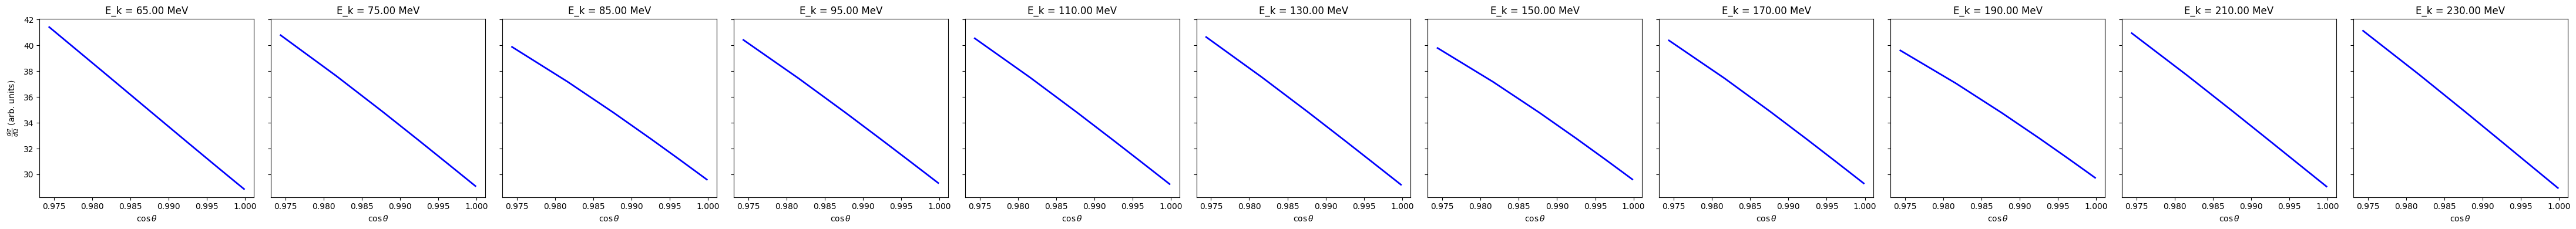

In [27]:
import torch
import math
import matplotlib.pyplot as plt
import numpy as np

# --- from your data ---
E_sec_exp = torch.tensor(sorted(df['E_sec'].unique()), dtype=torch.float32) / 1e6
E_inc_unique = torch.tensor(sorted(df['E_inc'].unique()), dtype=torch.float32) / 1e6
cos_theta_exp = torch.tensor(sorted(np.cos(np.radians(df['theta'].unique()))), dtype=torch.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
B = len(E_inc_unique)  # one batch per experimental incoming energy
N = 2000               # MC samples per Ek

# Expand energies to batch
Ek_batch = E_inc_unique.to(device)  # shape [B]

# Random Monte Carlo parameters
r1 = torch.rand((B, N), device=device)
r2 = torch.rand((B, N), device=device) * 2 - 1
r3 = torch.rand((B, N), device=device) * 2 * math.pi - math.pi

# Create pipeline
pipeline = ACSPipeline(cos_theta_eval=cos_theta_exp).to(device)

# Run simulation
with torch.no_grad():
    dsigma = pipeline(Ek_batch, r1, r2, r3)  # shape [B, M]

print("dsigma shape:", dsigma.shape)

# Plot results
fig, axes = plt.subplots(1, B, figsize=(4 * B, 4), sharey=True)
if B == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    ax.plot(cos_theta_exp.cpu(), dsigma[i].cpu(), 'b-', lw=2)
    ax.set_title(f"E_k = {Ek_batch[i].item():.2f} MeV")
    ax.set_xlabel(r"$\cos\theta$")
    if i == 0:
        ax.set_ylabel(r"$\frac{d\sigma}{d\Omega}$ (arb. units)")

plt.tight_layout()
plt.show()


In [ ]:
# Create pipeline
pipeline = ACSPipeline(cos_theta_eval=cos_theta_exp).to(device)

Ek_batch = torch.tensor([70.0], device=device)  # Example single energy, shape [B]

r1 = torch.tensor([[0.5]], device=device)
r1 = torch.tensor([[0.5]], device=device)
r1 = torch.tensor([[0.5]], device=device)


# Run simulation
with torch.no_grad():
    dsigma = pipeline(Ek_batch, r1, r2, r3)

dsigma

tensor([[41.4214, 37.8452, 34.8394, 32.4355, 30.6419, 29.4540, 28.8631],
        [40.7912, 37.6427, 34.8704, 32.5839, 30.8435, 29.6766, 29.0923],
        [39.8849, 37.1870, 34.7702, 32.7457, 31.1853, 30.1295, 29.5979],
        [40.4265, 37.4287, 34.8008, 32.6370, 30.9902, 29.8855, 29.3320],
        [40.5488, 37.5031, 34.8266, 32.6201, 30.9402, 29.8132, 29.2486],
        [40.6500, 37.5458, 34.8313, 32.6003, 30.9048, 29.7686, 29.1998],
        [39.7981, 37.1754, 34.7881, 32.7705, 31.2078, 30.1476, 29.6131],
        [40.3864, 37.4547, 34.8383, 32.6599, 30.9910, 29.8672, 29.3030],
        [39.6116, 37.0638, 34.7521, 32.7986, 31.2838, 30.2549, 29.7356],
        [40.9506, 37.6733, 34.8420, 32.5374, 30.7985, 29.6389, 29.0598],
        [41.1341, 37.7737, 34.8713, 32.5091, 30.7271, 29.5391, 28.9461]])

In [15]:
# import torch
# import numpy as np

# # Sample parameters
# B = 2000
# Ek = torch.full((B,), 65.0)
# uniform_samples = torch.rand((B, 3), device=device)  # uniform [0,1)

# r1 = uniform_samples[:, 0]                            # stays in [0, 1)
# r2 = uniform_samples[:, 1] * 2 - 1                    # maps [0,1) -> [-1, 1)
# r3 = uniform_samples[:, 2] * 2 * torch.pi - torch.pi  # maps [0,1) -> [-π, π)

# E_sec_exp = torch.tensor(sorted(df['E_sec'].unique()), dtype=torch.float32)
# E_sec_exp = E_sec_exp / 1e6
# cos_theta_exp = torch.tensor(sorted(np.cos(np.radians(df['theta'].unique()))), dtype=torch.float32)

# ecs_pipeline = ECSPipeline(E_eval=E_sec_exp)
# acs_pipeline = ACSPipeline(cos_theta_eval=cos_theta_exp)

# dsigma_dE_sim = ecs_pipeline(Ek, r1, r2, r3)            # shape matches len(E_sec_exp)
# dsigma_dOmega_sim = acs_pipeline(Ek, r1, r2, r3)        # shape matches len(cos_theta_exp)


In [16]:
# dsigma_dE_sim.size(), dsigma_dOmega_sim.size()

# dsigma_dE_sim
# dsigma_dOmega_sim


In [17]:
# import matplotlib.pyplot as plt

# # Plot energy spectrum
# plt.figure()
# plt.plot(E_sec_exp.numpy(), dsigma_dE_sim.detach().numpy())
# plt.xlabel("Proton Energy (MeV)")
# plt.ylabel("dσ/dE (arb. units)")
# plt.title("Differential Cross Section w.r.t Energy")
# plt.grid(True)

# # Plot angular distribution
# plt.figure()
# plt.plot(cos_theta_exp.numpy(), dsigma_dOmega_sim.detach().numpy())
# plt.xlabel("cos(θ_lab)")
# plt.ylabel("dσ/dΩ (arb. units)")
# plt.title("Differential Cross Section w.r.t Angle")
# plt.grid(True)

# plt.show()

In [31]:
# import torch.nn.functional as F

# def kl_loss_stable(simulated_ddcs, experimental_ddcs, eps=1e-8):
#     # Normalize to distributions
#     sim_sum = simulated_ddcs.sum(dim=-1, keepdim=True) + eps
#     exp_sum = experimental_ddcs.sum(dim=-1, keepdim=True) + eps

#     sim_dist = simulated_ddcs / sim_sum
#     exp_dist = experimental_ddcs / exp_sum

#     # Clamp for numerical safety
#     sim_dist = torch.clamp(sim_dist, min=eps)
#     exp_dist = torch.clamp(exp_dist, min=eps)

#     # Compute log probabilities
#     log_sim = sim_dist.log()
#     # log_exp = exp_dist.log()

#     # Final KL divergence
#     kl = F.kl_div(log_sim, exp_dist, reduction='batchmean', log_target=False)

#     if torch.isnan(kl):
#         print("KL loss is NaN")
#         print("sim_dist:", sim_dist)
#         print("exp_dist:", exp_dist)

#     return kl

import torch
import torch.nn.functional as F

def kl_plus_sum_mse_loss(simulated_ddcs, experimental_ddcs, eps=1e-8):
    # --- KL part (shape) ---
    sim_sum = simulated_ddcs.sum(dim=-1, keepdim=True) + eps
    exp_sum = experimental_ddcs.sum(dim=-1, keepdim=True) + eps

    sim_dist = simulated_ddcs / sim_sum
    exp_dist = experimental_ddcs / exp_sum

    sim_dist = torch.clamp(sim_dist, min=eps)
    exp_dist = torch.clamp(exp_dist, min=eps)

    log_sim = sim_dist.log()
    kl = F.kl_div(log_sim, exp_dist, reduction='batchmean', log_target=False)

    # --- MSE part (scale/height) ---
    mse_sums = F.mse_loss(sim_sum, exp_sum)

    # Combine losses
    loss = kl + mse_sums

    if torch.isnan(loss):
        print("Loss is NaN")
        print("KL:", kl)
        print("MSE_sums:", mse_sums)

    return loss



In [32]:
# # ------------------------------------------------------------------
# # Hyper-parameters
# # ------------------------------------------------------------------
# n_in        = 3       # number of parameters, i.e., random numbers needed in the simulation
# n_hidden    = 12      # number of hidden neurons in the network, at each layer
# n_layers    = 3       # number of hidden layers in the network
# n_out       = n_in    # must match the number of output parameters
# batch_size  = 2_000   # samples of random number per batch, to build the distribution. Larger is better, but slower
# epochs      = 3   # number of epochs to train the network
# lr          = 1e-3    # learning rate for the optimizer

# # ------------------------------------------------------------------
# # MLP producing seeds in [0,1]^7
# # ------------------------------------------------------------------
# def make_mlp(n_in, n_hidden, n_layers, n_out):
#     layers, d = [], n_in
#     for _ in range(n_layers):
#         layers += [nn.Linear(d, n_hidden), nn.ReLU()]
#         d = n_hidden
#     layers += [nn.Linear(d, n_out), nn.Sigmoid()]
#     # layers += [nn.Linear(d, n_out), nn.Tanh()]
#     return nn.Sequential(*layers)

# net       = make_mlp(n_in, n_hidden, n_layers, n_out).to(device)
# optimiser = optim.Adam(net.parameters(), lr=lr)

# # ------------------------------------------------------------------

# ------------------------------------------------------------------
# Hyper-parameters
# ------------------------------------------------------------------
n_in        = 3       # number of parameters, i.e., random numbers needed in the simulation
n_lamda     = 1       # number of untrainable external parameter dependencies
n_hidden    = 12      # number of hidden neurons in the network, at each layer
n_layers    = 3       # number of hidden layers in the network
n_out       = n_in    # must match the number of output parameters
batch_size  = 2_000   # samples of random number per batch, to build the distribution. Larger is better, but slower
epochs      = 1000#0   # number of epochs to train the network
lr          = 1e-3    # learning rate for the optimizer

# ------------------------------------------------------------------
# MLP producing seeds in [0,1]
# ------------------------------------------------------------------
def make_mlp(n_in, n_lamda, n_hidden, n_layers, n_out):
    layers, d = [], n_in + n_lamda
    for _ in range(n_layers):
        layers += [nn.Linear(d, n_hidden), nn.ReLU()]
        d = n_hidden
    layers += [nn.Linear(d, n_out), nn.Sigmoid()]
    return nn.Sequential(*layers)

net       = make_mlp(n_in, n_lamda, n_hidden, n_layers, n_out).to(device)
optimiser = optim.Adam(net.parameters(), lr=lr)
# ------------------------------------------------------------------

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import trange

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------
# Prep
# -------------

E_sec_exp = torch.tensor(sorted(df['E_sec'].unique()), dtype=torch.float32) / 1e6
E_inc_unique = torch.tensor(sorted(df['E_inc'].unique()), dtype=torch.float32) / 1e6
cos_theta_exp = torch.tensor(sorted(np.cos(np.radians(df['theta'].unique()))), dtype=torch.float32)

# ecs_pipeline = ECSPipeline(E_eval=E_sec_exp).to(device)
acs_pipeline = ACSPipeline(cos_theta_eval=cos_theta_exp).to(device)

# -------------
# Training loop
# -------------

# net.train()
# for epoch in trange(epochs, desc="Training Epochs"):
#     for i in range(len(integrated_results)):

#         # Sample random inputs and feed to ML
#         uniform_samples = torch.rand((batch_size, n_in), device=device)  # uniform [0,1)
#         uniform_samples.requires_grad_(True)

#         ######################NEW
#         Ek = integrated_results[i]['E_inc'] / 1e6 # Sim code works in MeV (maybe I should have coded it in eV)
#         # prepare axis for broadcasting
#         Ek_expanded = Ek.expand(batch_size, 1)  # shape: [batch_size, 1]

#         # Concatenate Ek with the uniform samples to create network input
#         net_input = torch.cat([uniform_samples, Ek_expanded], dim=1).to(device)  # shape: [batch_size, 4]


#         t = net(net_input)  # Output shape: [batch_size, 3]

#         r1 = t[:, 0]                            # in [0,1]
#         r2 = t[:, 1] * 2 - 1                    # map [0,1] -> [-1,1]
#         r3 = t[:, 2] * 2 * torch.pi - torch.pi  # map [0,1] -> [-π, π]

#         if torch.isnan(Ek).any() or torch.isnan(r1).any():
#             raise ValueError("NaNs in simulation inputs!")

#         # dsigma_dE_sim = ecs_pipeline(Ek, r1, r2, r3)           
#         dsigma_dOmega_sim = acs_pipeline(Ek, r1, r2, r3)  

#         # dsigma_dOmega_exp = dsigma_dOmega[i].to(device)
#         dsigma_dOmega_exp = integrated_results[i]['int_over_E_sec']

#         assert dsigma_dOmega_sim.shape == dsigma_dOmega_exp.shape, f"Shape mismatch: sim {dsigma_dOmega_sim.shape}, exp {dsigma_dOmega_exp.shape}"


#         loss = kl_loss_stable(dsigma_dOmega_sim, dsigma_dOmega_exp)

#         #DEBUG
#         # print("Loss:", loss.item())
#         if torch.isnan(loss) or torch.isinf(loss):
#             raise ValueError("Loss contains NaN or Inf!")

#         if torch.isnan(loss):
#             raise ValueError("Loss is NaN — check KDE output or input simulation.")

#         # Backprop
#         optimiser.zero_grad()

#         # loss.backward()
#         # #DEBUG
#         with torch.autograd.detect_anomaly():
#             loss.backward(retain_graph=True)

#         optimiser.step()
        
#         #DEBUG
#         # for name, param in net.named_parameters():
#         #     if param.grad is None:
#         #         print(f"{name}: grad is None")
#         #     else:
#         #         print(f"{name}: grad mean = {param.grad.abs().mean().item():.6e}")
        
#     if epoch % 100 == 0:
#         print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.6f}")

# -----------------------------------------------

# net.train()
# for i in range(len(integrated_results)):
#     for epoch in trange(epochs, desc='Training Epochs'):
#         uniform_samples = torch.rand((batch_size, n_in), device=device)

#         Ek = torch.tensor(integrated_results[i]['E_inc'], dtype=torch.float32, device=device) / 1e6
#         Ek_batch = Ek.expand(batch_size)

#         net_input = torch.cat([uniform_samples, Ek_batch.unsqueeze(1)], dim=1)
#         t = net(net_input)
#         r1 = t[:, 0]
#         r2 = t[:, 1] * 2 - 1
#         r3 = t[:, 2] * 2 * torch.pi - torch.pi

#         dsigma_dOmega_sim = acs_pipeline(Ek_batch, r1, r2, r3)
#         dsigma_dOmega_exp = integrated_results[i]['int_over_E_sec'].to(device)

#         assert dsigma_dOmega_sim.shape == dsigma_dOmega_exp.shape, f"Shape mismatch: sim {dsigma_dOmega_sim.shape}, exp {dsigma_dOmega_exp.shape}"

#         # loss = kl_loss_stable(dsigma_dOmega_sim, dsigma_dOmega_exp)
#         loss = kl_plus_sum_mse_loss(dsigma_dOmega_sim, dsigma_dOmega_exp)
#         if torch.isnan(loss) or torch.isinf(loss):
#             raise ValueError('Loss contains NaN or Inf!')

#         optimiser.zero_grad()
#         loss.backward()
#         optimiser.step()

#         if epoch % 100 == 0:
#             print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.6f}")

# -----------------------------------------------

net.train()

all_Ek = torch.stack([res['E_inc'] for res in integrated_results]) / 1e6  # (N,)
all_exp = torch.stack([res['int_over_E_sec'] for res in integrated_results])  # (N, dist_len)

all_Ek = all_Ek.to(device)
all_exp = all_exp.to(device)

num_samples = all_Ek.shape[0]

for epoch in trange(epochs, desc='Training Epochs'):
    # Sample random indices for batch
    idx = torch.randint(0, num_samples, (batch_size,), device=device)

    Ek_batch = all_Ek[idx]  # (B,)
    dsigma_dOmega_exp = all_exp[idx]  # (B, M)

    # Draw random uniform inputs for network
    # Shape: (B, N, n_in) — Monte Carlo samples per batch
    uniform_samples = torch.rand((batch_size, num_samples, n_in), device=device)

    # Append Ek to each MC sample row
    Ek_expanded = Ek_batch.unsqueeze(1).expand(-1, num_samples).unsqueeze(-1)  # (B, N, 1)
    net_input = torch.cat([uniform_samples, Ek_expanded], dim=-1)  # (B, N, n_in+1)

    # Flatten for network: (B*N, n_in+1)
    net_input_flat = net_input.reshape(-1, n_in + 1)

    # Predict r1, r2, r3 in flat form then reshape
    t = net(net_input_flat).reshape(batch_size, num_samples, 3)
    r1 = t[:, :, 0]
    r2 = t[:, :, 1] * 2 - 1
    r3 = t[:, :, 2] * 2 * torch.pi - torch.pi

    # Run simulation
    dsigma_dOmega_sim = acs_pipeline(Ek_batch, r1, r2, r3)  # (B, M)

    # Compute loss
    loss = kl_plus_sum_mse_loss(dsigma_dOmega_sim, dsigma_dOmega_exp)

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    # for name, param in net.named_parameters():
    #     if param.grad is None:
    #         print(f"{name}: grad is None")
    #     else:
    #         print(f"{name}: grad mean = {param.grad.abs().mean().item():.6e}")

    if epoch % 100 == 0:
        print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.6f}")



Training Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Epochs:   0%|          | 4/1000 [00:00<00:27, 35.62it/s]

Epoch   1 | Loss: 287845.281250


Training Epochs:  11%|█         | 109/1000 [00:02<00:18, 47.94it/s]

Epoch 101 | Loss: 100399.921875


Training Epochs:  21%|██        | 206/1000 [00:04<00:22, 35.16it/s]

Epoch 201 | Loss: 102356.687500


Training Epochs:  31%|███       | 308/1000 [00:07<00:16, 40.96it/s]

Epoch 301 | Loss: 97222.570312


Training Epochs:  41%|████      | 408/1000 [00:09<00:15, 38.85it/s]

Epoch 401 | Loss: 99321.609375


Training Epochs:  51%|█████     | 507/1000 [00:12<00:09, 51.72it/s]

Epoch 501 | Loss: 99968.523438


Training Epochs:  60%|██████    | 601/1000 [00:14<00:11, 34.17it/s]

Epoch 601 | Loss: 100203.750000


Training Epochs:  71%|███████   | 708/1000 [00:17<00:06, 45.86it/s]

Epoch 701 | Loss: 100305.375000


Training Epochs:  81%|████████  | 808/1000 [00:19<00:04, 46.73it/s]

Epoch 801 | Loss: 99433.867188


Training Epochs:  91%|█████████ | 909/1000 [00:21<00:01, 47.30it/s]

Epoch 901 | Loss: 99025.179688


Training Epochs: 100%|██████████| 1000/1000 [00:23<00:00, 42.11it/s]


In [ ]:
for name, param in net.named_parameters():
    if param.grad is None:
        print(f"{name}: grad is None")
    else:
        print(f"{name}: grad mean = {param.grad.abs().mean().item():.6e}")

0.weight: grad mean = 6.204795e-05
0.bias: grad mean = 1.373873e-05
2.weight: grad mean = 7.202506e-05
2.bias: grad mean = 3.694166e-05
4.weight: grad mean = 8.090553e-05
4.bias: grad mean = 6.722941e-05
6.weight: grad mean = 1.068010e-04
6.bias: grad mean = 1.888680e-04


In [ ]:
# Evaluation mode (affects dropout, batch norm etc.)
net.eval()  

with torch.no_grad():
    # Generate multiple batches for better statistics
    num_test_samples = 10000
    # x = (2.0 * torch.rand(num_test_samples, n_in, device=device) - 1.0)
    # t = net(x)
    # y = f_layer(t)[0]  # Flatten to 1D array
    
    # # Calculate basic statistics
    # mean_sim = y.mean()
    # std_sim = y.std()
    # mean_data = masses.mean()
    # std_data = masses.std()


    for i in range(len(integrated_results)):

        # Sample random inputs and feed to ML
        uniform_samples = torch.rand((num_test_samples, n_in), device=device)  # uniform [0,1)
        uniform_samples.requires_grad_(True)

        ######################NEW
        Ek = integrated_results[i]['E_inc'] / 1e6 # Sim code works in MeV (maybe I should have coded it in eV)
        # prepare axis for broadcasting
        Ek_expanded = Ek.expand(num_test_samples, 1)  # shape: [batch_size, 1]

        # Concatenate Ek with the uniform samples to create network input
        net_input = torch.cat([uniform_samples, Ek_expanded], dim=1).to(device)  # shape: [batch_size, 4]

        t = net(net_input)  # Output shape: [batch_size, 3]


        r1 = t[:, 0]                            # in [0,1]
        r2 = t[:, 1] * 2 - 1                    # map [0,1] -> [-1,1]
        r3 = t[:, 2] * 2 * torch.pi - torch.pi  # map [0,1] -> [-π, π]



        if torch.isnan(Ek).any() or torch.isnan(r1).any():
            raise ValueError("NaNs in simulation inputs!")

        # dsigma_dE_sim = ecs_pipeline(Ek, r1, r2, r3)           
        dsigma_dOmega_sim = acs_pipeline(Ek_expanded, r1, r2, r3)  

        # dsigma_dOmega_exp = dsigma_dOmega[i].to(device)
        dsigma_dOmega_exp = integrated_results[i]['int_over_E_sec']


        # Create figure
        plt.figure(figsize=(10, 6))

        # Plot 

        plt.plot(integrated_results[i]['theta'].numpy(), dsigma_dOmega_sim.cpu().numpy(), label='Simulated', color='blue', linewidth=2)
        plt.plot(integrated_results[i]['theta'].numpy(), dsigma_dOmega_exp.cpu().numpy(), label='Experimental', color='orange', linestyle='--', linewidth=2)

        # Formatting
        plt.xlabel("theta [deg]", fontsize=12)
        plt.ylabel(r"$\frac{d\sigma}{d\Omega}$", fontsize=12)
        plt.title(r"$\frac{d\sigma}{d\Omega}$ @" + f'{Ek} MeV', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# # Print KS test results
# from scipy import stats
# ks_stat, p_value = stats.ks_2samp(y.numpy(), masses.numpy())
# print(f"\nKS Test: D={ks_stat:.3f}, p-value={p_value:.3f}")
# print(f"Mean difference: {(mean_sim-mean_data):.2f} GeV")
# print(f"Std deviation ratio: {(std_sim/std_data):.2f}")

tensor([[[0.7747, 0.1999, 0.1856],
         [0.2878, 0.7368, 0.2091],
         [0.1786, 0.7590, 0.7013],
         ...,
         [0.4761, 0.9782, 0.9433],
         [0.6996, 0.3554, 0.1038],
         [0.9249, 0.6134, 0.2456]],

        [[0.6276, 0.8891, 0.9986],
         [0.3059, 0.1352, 0.8337],
         [0.3353, 0.5277, 0.0840],
         ...,
         [0.4124, 0.3959, 0.7390],
         [0.1185, 0.3507, 0.4900],
         [0.0388, 0.4593, 0.2538]],

        [[0.4384, 0.3920, 0.2200],
         [0.8610, 0.2629, 0.1847],
         [0.5856, 0.7288, 0.8932],
         ...,
         [0.8969, 0.3156, 0.7075],
         [0.4743, 0.9773, 0.0595],
         [0.0860, 0.9349, 0.2919]],

        [[0.3950, 0.9989, 0.4350],
         [0.5025, 0.7727, 0.4777],
         [0.5456, 0.9420, 0.2965],
         ...,
         [0.4321, 0.3966, 0.9927],
         [0.8624, 0.4265, 0.4995],
         [0.2174, 0.0201, 0.1163]]])
tensor([[[7.7465e-01, 1.9995e-01, 1.8559e-01, 7.5000e+07],
         [2.8780e-01, 7.3679e-01, 2.0

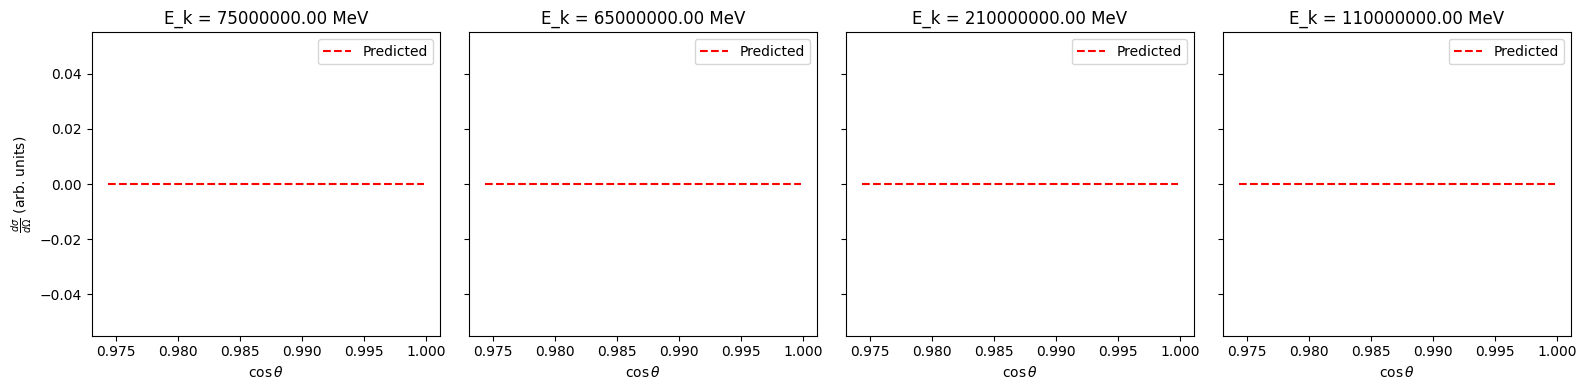

In [26]:
import torch
import matplotlib.pyplot as plt
import math

# Number of energies to plot
n_plots = 4
N = 2000  # Monte Carlo samples per energy

# Randomly choose some entries from integrated_results
chosen_idxs = torch.randperm(len(integrated_results))[:n_plots]

# Containers
Ek_chosen = []
exp_chosen = []

for idx in chosen_idxs:
    Ek_chosen.append(integrated_results[idx]['E_inc'].to(device))
    exp_chosen.append(integrated_results[idx]['int_over_E_sec'].to(device))

# Stack for batched processing
Ek_chosen = torch.stack(Ek_chosen)  # shape [B]
exp_chosen = torch.stack(exp_chosen)  # shape [B, M]
cos_theta_eval = acs_pipeline.kde_theta.x_eval  # already stored in KDE

# Generate network inputs
with torch.no_grad():
    # Random uniform features for MC (replace with your actual feature generation)
    uniform_samples = torch.rand((n_plots, N, n_in), device=device)

    print(uniform_samples)

    # Append Ek to each MC sample
    Ek_batch = Ek_chosen.unsqueeze(1).expand(-1, N)  # [B, N]
    net_input = torch.cat([uniform_samples, Ek_batch.unsqueeze(-1)], dim=-1)  # [B, N, n_in+1]

    print(net_input)

    # Run network
    t = net(net_input)
    r1 = t[..., 0]
    r2 = t[..., 1] * 2 - 1
    r3 = t[..., 2] * 2 * math.pi - math.pi

    # Run ACS pipeline (now vectorized)
    dsigma_pred = acs_pipeline(Ek_chosen, r1, r2, r3)  # [B, M]

    print(dsigma_pred)

# -------------------
# Plot
# -------------------
fig, axes = plt.subplots(1, n_plots, figsize=(4 * n_plots, 4), sharey=True)

for i, ax in enumerate(axes):
    # ax.plot(cos_theta_eval.cpu(), exp_chosen[i].cpu(), 'k-', label='Experimental')
    ax.plot(cos_theta_eval.cpu(), dsigma_pred[i].cpu(), 'r--', label='Predicted')
    ax.set_title(f"E_k = {Ek_chosen[i].item():.2f} MeV")
    ax.set_xlabel(r"$\cos\theta$")
    if i == 0:
        ax.set_ylabel(r"$\frac{{d\sigma}}{{d\Omega}}$ (arb. units)")
    ax.legend()

plt.tight_layout()
plt.show()
